# Python 2D-Dft Image processing
 

**In this project we want to do these step for our images:**
- transferm Image to matrix
- Apply dft
- Add filtre on it 
- inverse dft
- get the original image

In this project we use Fast 2D-DFT which has the $O(n^3)$

<h2>Importing our Library</h2>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

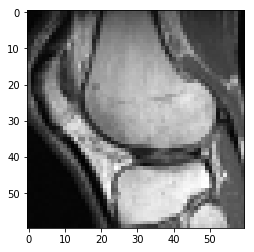

In [3]:
image = Image.open("knee.pgm").convert("L")

image = image.resize((60,60))
#get the pixels of image into array
f = np.asarray(image)
M, N = np.shape(f) # (img x, img y)
#show image
plt.imshow(f, cmap='gray')
plt.show()

<h3>Zero-Pad Image</h3>
<p>So we want to Pad our image with zeroes. our Image has the width and height with the size of <strong>M</strong> and <strong>N.&nbsp;</strong>The new array (Image) size is <strong>P</strong> and <strong>Q</strong>, where<strong> P = 2M-1</strong> and <strong>Q = 2N-1</strong>.</p>
<p>Our image is at the left top corner.</p>

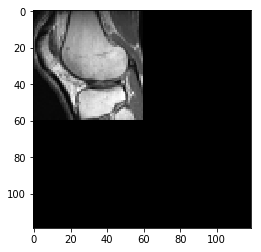

In [4]:
#padd image with size of P and Q
P,Q = M*2-1,N*2-1
shape = np.shape(f)
#our padded array
fp = np.zeros((P, Q))
#import our image into padded array
fp[:shape[0],:shape[1]] = f
plt.imshow(fp, cmap='gray',vmin=0, vmax=255)
plt.show()

to center its transform we should Multiply a new zero-padded image by this formula :

 $$ f_p(x,y) * (-1) ^{(x+y)}$$ 

In [5]:
def centerize(img):
    P,Q = img.shape
    center = np.zeros((P,Q))
    for x in range(P):
        for y in range(Q):
            center[x,y]=img[x,y]*np.power(-1,x+y)
    return center

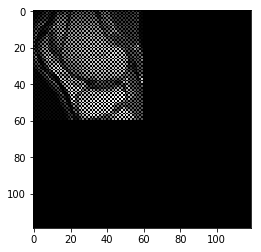

In [6]:
fpc = centerize(fp)

plt.imshow(fpc, cmap='gray',vmin=0, vmax=255)
plt.show()

# Fourier Transforms in Image Processing

We use 1D Dft for fast 2D DFT. First we process the column and then we process the rows.

 $$X_{lm} =   \sum_{k=0}^{M-1}X_{jk} e^{-2j\pi mn/N} $$

In [7]:
def DFT(fnList):
    U = len(fnList)
    FmList = np.zeros(U,dtype=complex)
    for m in range(U):
        Fm = 0.0
        for n in range(U):
            e = np.exp(-1j * 2 * np.pi * m * n / U)
            Fm += fnList[n]*e
        FmList[m] = Fm
    return FmList

the important key is that when we want to process the Inverse Dft first we calculate the complex for column and then the real for rows.

 $$X_{lm} =   \sum_{k=0}^{M-1}X_{m} e^{2j\pi mn/N} $$

In [8]:
def IDFT(FmList):
    U = len(FmList)
    fnList = np.zeros(U,dtype=complex)
    for n in range(U):
        fn = 0.0
        for m in range(U):
            e = np.exp(1j * 2 * np.pi * m * n / U)
            fn += FmList[m]*e
        pixel = fn/U
        fnList[n]=pixel
    return fnList

In [9]:
def IDFTR(FmList):
    U = len(FmList)
    fnList = np.zeros(U)
    for n in range(U):
        fn = 0.0
        for m in range(U):
            e = np.exp(1j * 2 * np.pi * m * n / U)
            fn += FmList[m]*e
        pixel = fn.real/U
        fnList[n]=pixel
    return fnList

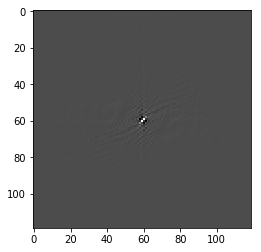

In [10]:
dft = dft1 =np.zeros((P,Q),dtype=complex)
#dft for columns
for i in range(P):
    dft[i] = DFT(fpc[i])
#dft for rows
for j in range(Q):
    dft1[:,j] = DFT(dft[:,j])
    
plt.imshow(dft1.real, cmap='gray')
plt.show()

## Ideal Low-Pass Filter

ideal low-pass filter rules:

$$ D(u,v)= \sqrt{u^2+v^2} $$

$$ H(u,v) = 1-> when D(u,v) ≤ D0 , otherwise = 0 $$

$$ D0 = Cut-Off $$

#### but because we padded the image we need to get the center of our filter into U/2 and V/2

In [11]:
def lowPass(padded,cut_off):
    
    #size of image
    U,V = np.shape(padded)
    #H is our filter
    H = np.zeros((U,V))
    D = np.zeros((U,V))
    U0 = int(U/2)
    V0 = int(V/2)
    #cut off
    D0 = cut_off
    for u in range(U):
        for v in range(V):
            u2 = np.power(u,2)
            v2 = np.power(v,2)
            D[u,v] = np.sqrt(u2+v2)
        
    for u in range(U):
        for v in range(V):        
            if D[np.abs(u-U0),np.abs(v-V0)] <= D0:
                H[u,v] = 1
            else:
                H[u,v] = 0
    return H

### for Apply the filter we get the multiply our image and our filter.


$$ G(k,l) = f(k,l)*H(k,l) $$

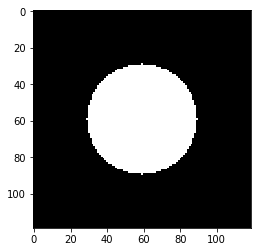

In [12]:
H = lowPass(dft1,30)
plt.imshow(H,cmap="gray")
plt.show()

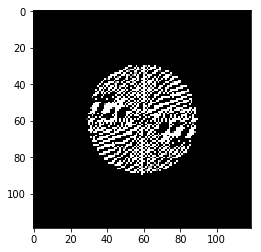

In [13]:
G= np.multiply(dft1,H)
plt.imshow(G.real,cmap="gray",vmin=1, vmax=255)
plt.show()

# Inverse DFT 
now we should get the inverse of dft to get our real image.

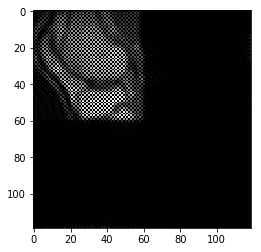

In [14]:
#Process Inverse DFT
idft = np.zeros((P,Q),dtype=complex)
idft1 = np.zeros((P,Q))
#Inverse for columns
for i in range(P):
    idft[i]=IDFT(G[i])
#Inverse for rows
for j in range(Q):
    idft1[:,j] = IDFTR(idft[:,j])

plt.imshow(idft1.real, cmap='gray',vmin=0, vmax=255)
plt.show()

###### so we neet to recenter our image again to get the full image

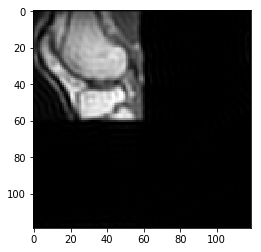

In [15]:
gp = centerize(idft1)
plt.imshow(gp,cmap="gray",vmin=0, vmax=255)
plt.show()

## Final step
we can obtain our final processed result by extractinh the M*N sub-region from top left of gp array

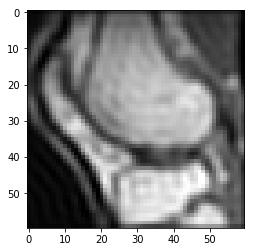

In [16]:
org_img=gp[:shape[0],:shape[1]]
plt.imshow(org_img,cmap='gray',vmin=0, vmax=255)
plt.show()